# 导入包
把上次的GAN中没用上的防止模型发散的技巧都用上。除了随机翻转训练判断器的标签。

没有正常测试样本集，只有正常训练样本集。用训练好的模型直接对正常训练样本集计算分数，用分数拟合正态分布，用正态分布计算每个异常样本部分的正确概率。

In [1]:
import pdb, os, shutil, datetime, math, sys

In [2]:
import scipy.stats as ss

In [3]:
from zlib import crc32

In [109]:
import json

In [4]:
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import pandas as pd

In [6]:
import tensorflow as tf

In [7]:
# 任务路径
strJobsDir = "../jobs_notest"

# 帧同步锁前

因为在MNIST中的样本有784个属性。用于分类的模型也只有2层。所以在整个解扰前的训练中，我使用的模型的层数均不变。

只随着样本属性的增加，增加每层的神经元个数。

## 训练函数
训练模型，模型用全局变量表示。

如果在某个迭代的最终损失不小于前一次迭代，终止循环，返回前一次迭代的生成器的三个元素。

In [8]:
def fn_train(oGAN): 
    def fn_getGLoss(tensorInput):
        # Apperant loss
        tensorEncodedSamples = oGAN.oSeqGe(tensorInput)
        tensorFakeSamples = oGAN.oSeqGd(tensorEncodedSamples)
        tensorApperantLoss = tf.reduce_mean(tf.losses.mean_absolute_error(tensorInput, tensorFakeSamples))

        # Latent loss
        tensorEncoded1Samples = oGAN.oSeqGe1(tensorFakeSamples)
        tensorLatentLoss = \
        tf.reduce_mean(tf.losses.mean_squared_error(tensorEncodedSamples, tensorEncoded1Samples))

        # Feature matching loss
        tensorPredFeatures = oGAN.oSeqDInner(tensorFakeSamples)
        tensorTrueFeatures = oGAN.oSeqDInner(tensorInput)
        tensorFeatureLoss = tf.reduce_mean(tf.losses.mean_squared_error(tensorPredFeatures, tensorTrueFeatures))

        tensorGLoss = tensorApperantLoss + tensorLatentLoss + tensorFeatureLoss
        return tensorGLoss
    # 在每个epoch后存储最小的ALoss和对应的
    fGLossLast = np.inf

    # 开始训练，输出训练的开始时间和训练的结束时间
    print(datetime.datetime.now())
    for nEpoch in range(g_nEpochs):
        for tensorBatch in oDataset:
            # Train discriminator
            # Generator fake samples
            tensorEncodedSamples = oGAN.oSeqGe(tensorBatch)
            tensorFakeSamples = oGAN.oSeqGd(tensorEncodedSamples)
            with tf.GradientTape() as oGradientTapeD:
                # Train discriminator with real samples
                tensorLabels = tf.random.uniform(minval=0.7, maxval=1.2, seed=42, shape=(tensorBatch.shape[0], 1))
                tensorPreds = oGAN.oSeqD(tensorBatch)
                tensorDLossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(tensorLabels, tensorPreds))
            listDGradients = oGradientTapeD.gradient(tensorDLossR, oGAN.oSeqD.trainable_variables)
            oOptimizerD.apply_gradients(zip(listDGradients, oGAN.oSeqD.trainable_variables))
            with tf.GradientTape() as oGradientTapeD:
                # Train discriminator with fake samples
                tensorLabels = tf.random.uniform(minval=0., maxval=0.3, seed = 42, shape=(tensorFakeSamples.shape[0], 1))
                tensorPreds = oGAN.oSeqD(tensorFakeSamples)
                tensorDLossF = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(tensorLabels, tensorPreds))
            listDGradients = oGradientTapeD.gradient(tensorDLossF, oGAN.oSeqD.trainable_variables)
            oOptimizerD.apply_gradients(zip(listDGradients, oGAN.oSeqD.trainable_variables))
            tensorDLoss = tensorDLossR + tensorDLossF
            with oSummaryWriterDLoss.as_default():
                tf.summary.scalar("D_Loss", tensorDLoss, g_nStep)

            # Train genertor
            with tf.GradientTape() as oGradientTapeG:
                tensorGLoss = fn_getGLoss(tensorBatch)
            # Insert all generator trainable variables into a list
            listTrainableGVariables = []
            listTrainableGVariables.extend(oGAN.oSeqGe.trainable_variables)
            listTrainableGVariables.extend(oGAN.oSeqGd.trainable_variables)
            listTrainableGVariables.extend(oGAN.oSeqGe1.trainable_variables)

            listGGradients = oGradientTapeG.gradient(tensorGLoss, listTrainableGVariables)
            oOptimizerG.apply_gradients(zip(listGGradients, listTrainableGVariables))
            with oSummaryWriterALoss.as_default():
                tf.summary.scalar("A_loss", tensorGLoss, g_nStep)

            g_nStep = g_nStep + 1
            
        # 在整个训练集上计算generator的损失，并比较和上一次迭代的损失，如果小于上一次迭代，更新损失和最有模型；反之停止训练
        tensorGLossOverTotalSamples = fn_getGLoss(g_tensorNormalTrainingSamples)
        if fGLossLast > tensorGLossOverTotalSamples.numpy():
            fGLossLast = tensorGLossOverTotalSamples.numpy()
            oSeqGe = oGAN.oSeqGe
            oSeqGd = oGAN.oSeqGd
            oSeqGe1 = oGAN.oSeqGe1
        # 输出进度
        fn_printBar(nEpoch)
    print(datetime.datetime.now())

    

## 算分函数

计算分数的函数
通过输入样本集和Ge，Gd，Ge1输出样本集中每个样本的分数的函数。

In [77]:
def fn_scoreForASample(npSample):
    tensorSample = tf.constant(npSample[np.newaxis, :])
    tensorEncodedSample = oSeqGe(tensorSample)
    tensorFakeSample = oSeqGd(tensorEncodedSample)
    # Apperant loss
    tensorApperantLoss = tf.reduce_mean(tf.losses.mean_absolute_error(tensorSample, tensorFakeSample))

    # Latent loss
    tensorEncoded1Sample = oSeqGe1(tensorFakeSample)
    tensorLatentLoss = \
        tf.reduce_mean(tf.losses.mean_squared_error(tensorEncodedSample, tensorEncoded1Sample))

    tensorScore = tensorApperantLoss + tensorLatentLoss
    return tensorScore.numpy()

def fn_score(pdDfSamples):
    if pdDfSamples.empty:
        pdDfScores = pd.DataFrame(columns=["score"])
        return pdDfScores
    
    pdDfScores = pd.DataFrame(data=np.apply_along_axis(fn_scoreForASample, 1, pdDfSamples.values), columns=["score"], \
         index=pdDfSamples.index)
    return pdDfScores

## 输出训练进度函数

In [10]:
def fn_printBar(nEpoch):
    sys.stdout.write(f"\r{nEpoch:d}/{g_nEpochs}")
    sys.stdout.flush()

## 通过任务文件夹路径获取解调器文件夹路径函数

In [11]:
def fn_getDemodDirsOfAJob(strJobDir):
    liststrDemodDirs = [os.path.join(strJobDir, strName) for strName in os.listdir(strJobDir) if "Demod" in strName]
    return liststrDemodDirs

## 中频控制

利用中频控制的训练样本训练模型，再用模型为测试样本打分。分数越高样本越异常。为测试集打分时，测试集中的正常样本应该分数很低，异常样本中的有一部分应该分数低，一部分分数高。

### 构造建立模型
5个属性

为了能够将训练好的模型保存起来，每个独立的模型的第一层都是tf.keras.Input(shape=(inputshape, ))

In [18]:
class GANifu(object):
    def __init__(self):
        self.fn_makeGenerator()
        self.fn_makeDiscriminator()
        
    def fn_makeGenerator(self):
        self.oSeqGe = tf.keras.Sequential(name="Ge")
        self.oSeqGe.add(tf.keras.Input(shape=(5,)))
        self.oSeqGe.add(tf.keras.layers.Dense(2, kernel_initializer="he_normal"))
        self.oSeqGe.add(tf.keras.layers.LeakyReLU())
        self.oSeqGe.add(tf.keras.layers.BatchNormalization())
        self.oSeqGe.add(tf.keras.layers.Dense(2, kernel_initializer="he_normal"))
        self.oSeqGe.add(tf.keras.layers.LeakyReLU())

        self.oSeqGd = tf.keras.Sequential(name="Gd")
        self.oSeqGd.add(tf.keras.Input(shape=(2,)))
        self.oSeqGd.add(tf.keras.layers.Dense(2, kernel_initializer="he_normal"))
        self.oSeqGd.add(tf.keras.layers.LeakyReLU())
        self.oSeqGd.add(tf.keras.layers.BatchNormalization())
        self.oSeqGd.add(tf.keras.layers.Dense(5, activation = tf.keras.activations.tanh, kernel_initializer="he_normal"))
        
        self.oSeqGe1 = tf.keras.Sequential(name="Ge1")
        self.oSeqGe1.add(tf.keras.Input(shape=(5,)))
        self.oSeqGe1.add(tf.keras.layers.Dense(2, kernel_initializer="he_normal"))
        self.oSeqGe1.add(tf.keras.layers.LeakyReLU())
        self.oSeqGe1.add(tf.keras.layers.BatchNormalization())
        self.oSeqGe1.add(tf.keras.layers.Dense(2, kernel_initializer="he_normal"))
        self.oSeqGe1.add(tf.keras.layers.LeakyReLU())
        
    def fn_makeDiscriminator(self):
        self.oSeqDInner = tf.keras.Sequential(name="DInner")
        self.oSeqDInner.add(tf.keras.Input(shape=(5,)))
        self.oSeqDInner.add(tf.keras.layers.Dense(2, kernel_initializer="he_normal"))
        self.oSeqDInner.add(tf.keras.layers.LeakyReLU())
        self.oSeqDInner.add(tf.keras.layers.BatchNormalization())
        self.oSeqDInner.add(tf.keras.layers.Dense(2, kernel_initializer="he_normal"))
        self.oSeqDInner.add(tf.keras.layers.LeakyReLU())
        self.oSeqDInner.add(tf.keras.layers.BatchNormalization())

        self.oSeqD = tf.keras.Sequential([
            self.oSeqDInner,
            tf.keras.layers.Dense(1, activation = tf.keras.activations.sigmoid)
        ], name="D")

In [19]:
# 新建模型
tf.keras.backend.clear_session()
oGANifu = GANifu()

### 构造数据集

In [20]:
g_nFeatures = 5
g_nBatchSize = 256

def fn_splitCsvLine(strLine):
    tensorDefs = [0.] * g_nFeatures
    tensorRecord = tf.io.decode_csv(strLine, record_defaults=tensorDefs)
    tensorX = tf.stack(tensorRecord)
    return tensorX

oDataset = tf.data.Dataset.list_files(strJobsDir + "/*/*/parts/sync/ifu/samples/normal/train/preprocessed/samples.csv")
oDataset = oDataset.interleave(lambda strSamplesFile: tf.data.TextLineDataset(strSamplesFile).skip(1), \
                              cycle_length=5, num_parallel_calls=5)
oDataset = oDataset.map(fn_splitCsvLine, 5)
oDataset = oDataset.shuffle(1000)
oDataset= oDataset.batch(g_nBatchSize)

In [14]:
# 读入所有的训练样本，从而通过shape属性得到训练集大小，存入全局变量中
listPreprocessedNormalTrainingSamples = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strPreprocessedNormalTrainingSamplesFile = os.path.join(strDemodDir, \
                                                   "parts/sync/ifu/samples/normal/train/preprocessed/samples.csv")
        pdDfPreprocessedNormalTrainingSamples = pd.read_csv(strPreprocessedNormalTrainingSamplesFile)
        listPreprocessedNormalTrainingSamples.append(pdDfPreprocessedNormalTrainingSamples)
pdDfPreprocessedNormalTrainingSamples = pd.concat(listPreprocessedNormalTrainingSamples)
g_tensorNormalTrainingSamples = tf.constant(pdDfPreprocessedNormalTrainingSamples.values, dtype=tf.float32)
g_nTrainingSize = len(g_tensorNormalTrainingSamples)

### 训练

In [21]:
# 构造优化器。
# 利用ExponentialDecay的方法构造优化器。
g_nEpochs = 250
nSteps = g_nEpochs * g_nTrainingSize // g_nBatchSize
oExponentialDecay = tf.keras.optimizers.schedules.ExponentialDecay(1e-2, nSteps, 1e-1)
oOptimizerG = tf.keras.optimizers.Adam(learning_rate=oExponentialDecay)
oOptimizerD = tf.keras.optimizers.SGD(learning_rate=oExponentialDecay)

In [22]:
# 构造日志
strPrefix = datetime.datetime.now().strftime("%H_%M_%S")
strPrefix = "{}".format(strPrefix)
oSummaryWriterDLoss = tf.summary.create_file_writer("logs/no_test/ifu/" + strPrefix + "_D")
oSummaryWriterALoss = tf.summary.create_file_writer("logs/no_test/ifu/" + strPrefix + "_A")

In [23]:
oSeqGe, oSeqGd, oSeqGe1 = fn_train(oGANifu)

2020-03-01 09:43:04.274688
249/250

In [27]:
# 保存模型
oSeqGe.save("models/no_test/sync/ifu/Ge.h5")
oSeqGd.save("models/no_test/sync/ifu/Gd.h5")
oSeqGe1.save("models/no_test/sync/ifu/Ge1.h5")

### 评估
然后利用训练好的模型算出测试集样本的分数，存档。

从文件夹中载入训练好的模型。

遍历每个解调器的测试集，将相应的分数存入preprocessed/scores.csv中

In [137]:
oSeqGe = tf.keras.models.load_model("models/notest/sync/ifu/Ge.h5")
oSeqGd = tf.keras.models.load_model("models/notest/sync/ifu/Gd.h5")
oSeqGe1 = tf.keras.models.load_model("models/notest/sync/ifu/Ge1.h5")

计算测试样本分数并存档
执行后：
* samples/
    * normal/
        * test/
            * preprocessed/
                * samples.csv
                * scores.csv
    * abnormal/
        * preprocessed/
            * samples.csv
            * scores.csv
      
在分数后面要添上由解调器名和rectime组成的id，方便画图的时候把同一解调器在同一任务的样本分开。画图的时候要把id和总的横坐标值取模，模的结果作为最终的横坐标。

In [138]:
# 算出正常训练集和异常测试集的分数
# train samples
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        strSamplesDir = os.path.join(strDemodDir, "parts/sync/ifu/samples/normal/train")
        pdDfPreprocessedSamples = pd.read_csv(\
              os.path.join(strSamplesDir, "preprocessed/samples.csv"))
        pdDfSamples = pd.read_csv(os.path.join(strSamplesDir, "samples.csv"), index_col="RECTIME")
        # 分数csv包含scores列
        pdDfScores = fn_score(pdDfPreprocessedSamples)
        pdDfScores.index = pdDfSamples.index

        pdDfScores.to_csv(os.path.join(strSamplesDir, "preprocessed/scores.csv"), index_label="RECTIME")
        
# Abnormal samples
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        strSamplesDir = os.path.join(strDemodDir, "parts/sync/ifu/samples/abnormal")
        pdDfPreprocessedSamples = pd.read_csv(os.path.join(strSamplesDir, "preprocessed/samples.csv"), index_col="RECTIME")
        pdDfScores = fn_score(pdDfPreprocessedSamples)

        pdDfScores.to_csv(os.path.join(strSamplesDir, "preprocessed/scores.csv"), index_label="RECTIME")

In [139]:
# 读入正常测试样本的分数，分别存入numpy数组
listScores = []
listX = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strNormalTestingScoresFile = os.path.join(strDemodDir, \
                                                  "parts/sync/ifu/samples/normal/train/preprocessed/scores.csv")
        pdDfNormalTestingScores = pd.read_csv(strNormalTestingScoresFile, index_col="RECTIME")
        
        if not pdDfNormalTestingScores.empty:
            listScores.append(pdDfNormalTestingScores["score"].values)
            
            # 分数的横坐标——用crc编码“解调器名+上报时间”
            strDemod = os.path.split(strDemodDir)[1]
            listX.append([crc32(str.encode(strDemod + strIndex)) for strIndex in pdDfNormalTestingScores.index])
            
npNormalScores = np.concatenate(listScores)
npNormalX = np.concatenate(listX)

In [140]:
# 读入异常测试样本的分数
listScores = []
listX = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strAbnormalTestingScoresFile = os.path.join(strDemodDir, \
                                                  "parts/sync/ifu/samples/abnormal/preprocessed/scores.csv")
        pdDfAbnormalTestingScores = pd.read_csv(strAbnormalTestingScoresFile, index_col="RECTIME")
        if not pdDfAbnormalTestingScores.empty:
            listScores.append(pdDfAbnormalTestingScores["score"].values)
            
             # 分数的横坐标——用crc编码“解调器名+上报时间”
            strDemod = os.path.split(strDemodDir)[1]
            listX.append([crc32(str.encode(strDemod + strIndex)) for strIndex in pdDfAbnormalTestingScores.index])
            
npAbnormalScores = np.concatenate(listScores)
npAbnormalX = np.concatenate(listX)

In [141]:
"""
通过正常训练样本的分数计算相应的正太分布，利用正态分布计算异常样本该部分正确的概率
"""
fMeanifu = np.mean(npNormalScores)
fSigmaifu = np.var(npNormalScores)
npAbnormalprob = np.apply_along_axis(lambda x: 1 if x <= fMeanifu else ss.norm.sf(x, fMeanifu, fSigmaifu), 1, \
     npAbnormalScores[:, np.newaxis])

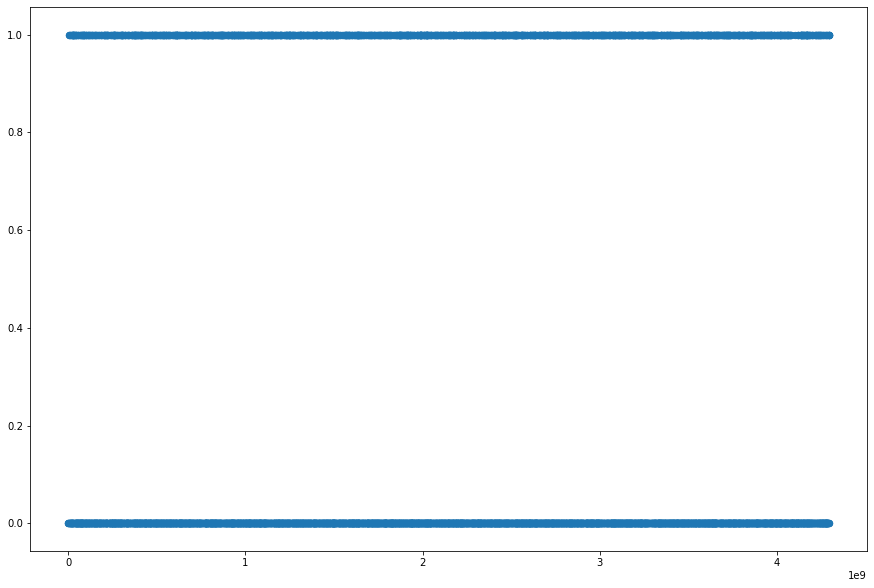

In [142]:
plt.figure(figsize=(15, 10))
plt.scatter(npAbnormalX, npAbnormalprob, s=40)
plt.show()

## 中频输入

### 构造建立模型

由于有7个属性，所以

In [25]:
class GANinput(object):
    def __init__(self):
        self.fn_makeGenerator()
        self.fn_makeDiscriminator()
        
    def fn_makeGenerator(self):
        self.oSeqGe = tf.keras.Sequential(name="Ge")
        self.oSeqGe.add(tf.keras.Input(shape=(7,)))
        self.oSeqGe.add(tf.keras.layers.Dense(6, kernel_initializer="he_normal"))
        self.oSeqGe.add(tf.keras.layers.LeakyReLU())
        self.oSeqGe.add(tf.keras.layers.BatchNormalization())
        self.oSeqGe.add(tf.keras.layers.Dense(6, kernel_initializer="he_normal"))
        self.oSeqGe.add(tf.keras.layers.LeakyReLU())

        self.oSeqGd = tf.keras.Sequential(name="Gd")
        self.oSeqGd.add(tf.keras.Input(shape=(6,)))
        self.oSeqGd.add(tf.keras.layers.Dense(6, kernel_initializer="he_normal"))
        self.oSeqGd.add(tf.keras.layers.LeakyReLU())
        self.oSeqGd.add(tf.keras.layers.BatchNormalization())
        self.oSeqGd.add(tf.keras.layers.Dense(7, activation = tf.keras.activations.tanh, kernel_initializer="he_normal"))
        
        self.oSeqGe1 = tf.keras.Sequential(name="Ge1")
        self.oSeqGe1.add(tf.keras.Input(shape=(7,)))
        self.oSeqGe1.add(tf.keras.layers.Dense(6, kernel_initializer="he_normal"))
        self.oSeqGe1.add(tf.keras.layers.LeakyReLU())
        self.oSeqGe1.add(tf.keras.layers.BatchNormalization())
        self.oSeqGe1.add(tf.keras.layers.Dense(6, kernel_initializer="he_normal"))
        self.oSeqGe1.add(tf.keras.layers.LeakyReLU())
        
    def fn_makeDiscriminator(self):
        self.oSeqDInner = tf.keras.Sequential(name="DInner")
        self.oSeqDInner.add(tf.keras.Input(shape=(7,)))
        self.oSeqDInner.add(tf.keras.layers.Dense(6, kernel_initializer="he_normal"))
        self.oSeqDInner.add(tf.keras.layers.LeakyReLU())
        self.oSeqDInner.add(tf.keras.layers.BatchNormalization())
        self.oSeqDInner.add(tf.keras.layers.Dense(6, kernel_initializer="he_normal"))
        self.oSeqDInner.add(tf.keras.layers.LeakyReLU())
        self.oSeqDInner.add(tf.keras.layers.BatchNormalization())

        self.oSeqD = tf.keras.Sequential([
            self.oSeqDInner,
            tf.keras.layers.Dense(1, activation = tf.keras.activations.sigmoid)
        ], name="D")

In [26]:
# 新建模型
tf.keras.backend.clear_session()
oGANinput = GANinput()

### 构造数据集

In [27]:
g_nFeatures = 7
g_nBatchSize = 256

def fn_splitCsvLine(strLine):
    tensorDefs = [0.] * g_nFeatures
    tensorRecord = tf.io.decode_csv(strLine, record_defaults=tensorDefs)
    tensorX = tf.stack(tensorRecord)
    return tensorX

oDataset = tf.data.Dataset.list_files(strJobsDir + "/*/*/parts/sync/input/samples/normal/train/preprocessed/samples.csv")
oDataset = oDataset.interleave(lambda strSamplesFile: tf.data.TextLineDataset(strSamplesFile).skip(1), \
                              cycle_length=5, num_parallel_calls=5)
oDataset = oDataset.map(fn_splitCsvLine, g_nFeatures)
oDataset = oDataset.shuffle(1000)
oDataset = oDataset.batch(g_nBatchSize)

In [21]:
# 读入所有的训练样本，从而通过shape属性得到训练集大小，存入全局变量中
listPreprocessedNormalTrainingSamples = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strPreprocessedNormalTrainingSamplesFile = os.path.join(strDemodDir, \
                                                   "parts/sync/input/samples/normal/train/preprocessed/samples.csv")
        pdDfPreprocessedNormalTrainingSamples = pd.read_csv(strPreprocessedNormalTrainingSamplesFile)
        listPreprocessedNormalTrainingSamples.append(pdDfPreprocessedNormalTrainingSamples)
pdDfPreprocessedNormalTrainingSamples = pd.concat(listPreprocessedNormalTrainingSamples)
g_tensorNormalTrainingSamples = tf.constant(pdDfPreprocessedNormalTrainingSamples.values, dtype=tf.float32)
g_nTrainingSize = len(g_tensorNormalTrainingSamples)

### 训练

In [28]:
# g_nTrainingSize在中频控制已经设置好了
g_nEpochs = 250
nSteps = g_nEpochs * g_nTrainingSize // g_nBatchSize
oExponentialDecay = tf.keras.optimizers.schedules.ExponentialDecay(1e-2, nSteps, 1e-1)
oOptimizerG = tf.keras.optimizers.Adam(learning_rate=oExponentialDecay)
oOptimizerD = tf.keras.optimizers.SGD(learning_rate=oExponentialDecay)

In [29]:
# 构造日志
strPrefix = datetime.datetime.now().strftime("%H_%M_%S")
strPrefix = "{}".format(strPrefix)
oSummaryWriterDLoss = tf.summary.create_file_writer("logs/notest/sync/input/"  + "(7,6)_D")
oSummaryWriterALoss = tf.summary.create_file_writer("logs/notest/sync/input/" + "(7,6)_A")

In [30]:
oSeqGe, oSeqGd, oSeqGe1 = fn_train(oGANinput)

2020-03-01 12:52:17.228534
249/250

保存模型

In [32]:
oSeqGe.save("models/notest/sync/input/Ge(7,6).h5")
oSeqGd.save("models/notest/sync/input/Gd(7,6).h5")
oSeqGe1.save("models/notest/sync/input/Ge1(7,6).h5")

### 评估
然后利用训练好的模型算出测试集样本的分数，存档。

从文件夹中载入训练好的模型。

遍历每个解调器的测试集，将相应的分数存入preprocessed/scores.csv中

In [146]:
oSeqGe = tf.keras.models.load_model("models/notest/sync/input/Ge(7,6).h5")
oSeqGd = tf.keras.models.load_model("models/notest/sync/input/Gd(7,6).h5")
oSeqGe1 = tf.keras.models.load_model("models/notest/sync/input/Ge1(7,6).h5")

计算测试样本分数并存档
执行后：
* samples/
    * normal/
        * test/
            * preprocessed/
                * samples.csv
                * scores.csv
    * abnormal/
        * preprocessed/
            * samples.csv
            * scores.csv

In [147]:
# 算出正常训练集和异常测试集的分数
# train samples
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        strSamplesDir = os.path.join(strDemodDir, "parts/sync/input/samples/normal/train")
        pdDfPreprocessedSamples = pd.read_csv(\
              os.path.join(strSamplesDir, "preprocessed/samples.csv"))
        pdDfSamples = pd.read_csv(os.path.join(strSamplesDir, "samples.csv"), index_col="RECTIME")
        # 分数csv包含scores列
        pdDfScores = fn_score(pdDfPreprocessedSamples)
        pdDfScores.index = pdDfSamples.index

        pdDfScores.to_csv(os.path.join(strSamplesDir, "preprocessed/scores.csv"), index_label="RECTIME")
        
# Abnormal samples
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        strSamplesDir = os.path.join(strDemodDir, "parts/sync/input/samples/abnormal")
        pdDfPreprocessedSamples = pd.read_csv(os.path.join(strSamplesDir, "preprocessed/samples.csv"), index_col="RECTIME")
        pdDfScores = fn_score(pdDfPreprocessedSamples)

        pdDfScores.to_csv(os.path.join(strSamplesDir, "preprocessed/scores.csv"), index_label="RECTIME")

In [148]:
# 读入正常测试样本和异常测试样本的分数，分别存入numpy数组
listScores = []
listX = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strNormalTestingScoresFile = os.path.join(strDemodDir, \
                                                  "parts/sync/input/samples/normal/train/preprocessed/scores.csv")
        pdDfNormalTestingScores = pd.read_csv(strNormalTestingScoresFile, index_col="RECTIME")
        
        if not pdDfNormalTestingScores.empty:
            listScores.append(pdDfNormalTestingScores["score"].values)
            
            # 分数的横坐标——用crc编码“解调器名+上报时间”
            strDemod = os.path.split(strDemodDir)[1]
            listX.append([crc32(str.encode(strDemod + strIndex)) for strIndex in pdDfNormalTestingScores.index])
            
npNormalScores = np.concatenate(listScores)
npNormalX = np.concatenate(listX)

In [149]:
listScores = []
listX = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strAbnormalTestingScoresFile = os.path.join(strDemodDir, \
                                                  "parts/sync/input/samples/abnormal/preprocessed/scores.csv")
        pdDfAbnormalTestingScores = pd.read_csv(strAbnormalTestingScoresFile, index_col="RECTIME")
        if not pdDfAbnormalTestingScores.empty:
            listScores.append(pdDfAbnormalTestingScores["score"].values)
            
             # 分数的横坐标——用crc编码“解调器名+上报时间”
            strDemod = os.path.split(strDemodDir)[1]
            listX.append([crc32(str.encode(strDemod + strIndex)) for strIndex in pdDfAbnormalTestingScores.index])
            
npAbnormalScores = np.concatenate(listScores)
npAbnormalX = np.concatenate(listX)

In [150]:
"""
通过正常训练样本的分数计算相应的正太分布，利用正态分布计算异常样本该部分正确的概率
"""
fMeaninput = np.mean(npNormalScores)
fSigmainput = np.var(npNormalScores)
npAbnormalprob = np.apply_along_axis(lambda x: 1 if x <= fMeaninput else ss.norm.sf(x, fMeaninput, fSigmainput), 1, \
     npAbnormalScores[:, np.newaxis])

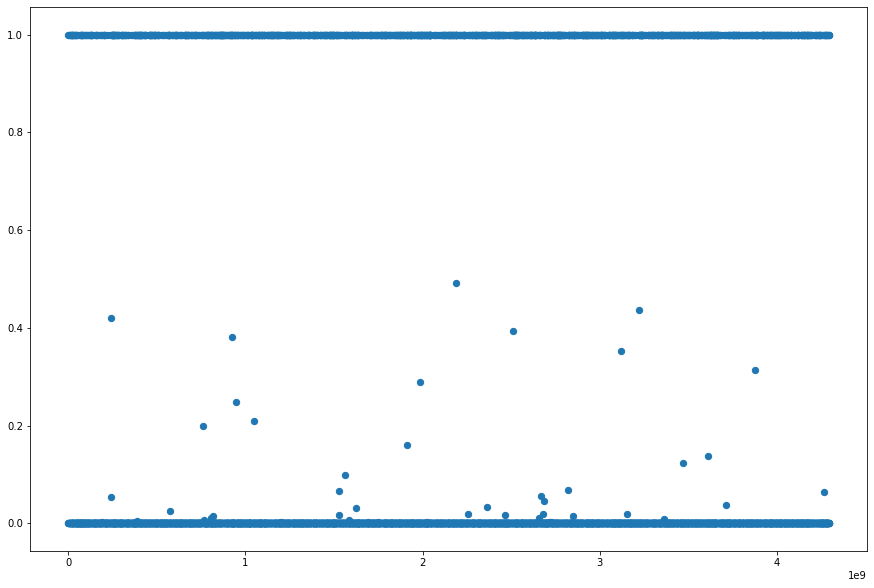

In [151]:
plt.figure(figsize=(15, 10))
plt.scatter(npAbnormalX, npAbnormalprob, s=40)
plt.show()

## 载波同步

### 构造建立模型

9个属性

In [89]:
class GANcarrier(object):
    def __init__(self):
        self.fn_makeGenerator()
        self.fn_makeDiscriminator()
        
    def fn_makeGenerator(self):
        self.oSeqGe = tf.keras.Sequential(name="Ge")
        self.oSeqGe.add(tf.keras.Input(shape=(9,)))
        self.oSeqGe.add(tf.keras.layers.Dense(7, kernel_initializer="he_normal"))
        self.oSeqGe.add(tf.keras.layers.LeakyReLU())
        self.oSeqGe.add(tf.keras.layers.BatchNormalization())
        self.oSeqGe.add(tf.keras.layers.Dense(7, kernel_initializer="he_normal"))
        self.oSeqGe.add(tf.keras.layers.LeakyReLU())

        self.oSeqGd = tf.keras.Sequential(name="Gd")
        self.oSeqGd.add(tf.keras.Input(shape=(7,)))
        self.oSeqGd.add(tf.keras.layers.Dense(7, kernel_initializer="he_normal"))
        self.oSeqGd.add(tf.keras.layers.LeakyReLU())
        self.oSeqGd.add(tf.keras.layers.BatchNormalization())
        self.oSeqGd.add(tf.keras.layers.Dense(9, activation = tf.keras.activations.tanh, kernel_initializer="he_normal"))
        
        self.oSeqGe1 = tf.keras.Sequential(name="Ge1")
        self.oSeqGe1.add(tf.keras.Input(shape=(9,)))
        self.oSeqGe1.add(tf.keras.layers.Dense(7, kernel_initializer="he_normal"))
        self.oSeqGe1.add(tf.keras.layers.LeakyReLU())
        self.oSeqGe1.add(tf.keras.layers.BatchNormalization())
        self.oSeqGe1.add(tf.keras.layers.Dense(7, kernel_initializer="he_normal"))
        self.oSeqGe1.add(tf.keras.layers.LeakyReLU())
        
    def fn_makeDiscriminator(self):
        self.oSeqDInner = tf.keras.Sequential(name="DInner")
        self.oSeqDInner.add(tf.keras.Input(shape=(9,)))
        self.oSeqDInner.add(tf.keras.layers.Dense(7, kernel_initializer="he_normal"))
        self.oSeqDInner.add(tf.keras.layers.LeakyReLU())
        self.oSeqDInner.add(tf.keras.layers.BatchNormalization())
        self.oSeqDInner.add(tf.keras.layers.Dense(7, kernel_initializer="he_normal"))
        self.oSeqDInner.add(tf.keras.layers.LeakyReLU())
        self.oSeqDInner.add(tf.keras.layers.BatchNormalization())

        self.oSeqD = tf.keras.Sequential([
            self.oSeqDInner,
            tf.keras.layers.Dense(1, activation = tf.keras.activations.sigmoid)
        ], name="D")

In [96]:
# 新建模型
tf.keras.backend.clear_session()
oGANcarrier = GANcarrier()

### 构造数据集

In [97]:
g_nFeatures = 9
g_nBatchSize = 256

def fn_splitCsvLine(strLine):
    tensorDefs = [0.] * g_nFeatures
    tensorRecord = tf.io.decode_csv(strLine, record_defaults=tensorDefs)
    tensorX = tf.stack(tensorRecord)
    return tensorX


oDataset = tf.data.Dataset.list_files(strJobsDir + "/*/*/parts/sync/carrier/samples/normal/train/preprocessed/samples.csv")
oDataset = oDataset.interleave(lambda strSamplesFile: tf.data.TextLineDataset(strSamplesFile).skip(1), \
                              cycle_length=5, num_parallel_calls=5)
oDataset = oDataset.map(fn_splitCsvLine, g_nFeatures)
oDataset = oDataset.shuffle(1000)
oDataset = oDataset.batch(g_nBatchSize)

In [92]:
# 读入所有的训练样本，从而通过shape属性得到训练集大小，存入全局变量中
listPreprocessedNormalTrainingSamples = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strPreprocessedNormalTrainingSamplesFile = os.path.join(strDemodDir, \
                                                   "parts/sync/carrier/samples/normal/train/preprocessed/samples.csv")
        pdDfPreprocessedNormalTrainingSamples = pd.read_csv(strPreprocessedNormalTrainingSamplesFile)
        listPreprocessedNormalTrainingSamples.append(pdDfPreprocessedNormalTrainingSamples)
pdDfPreprocessedNormalTrainingSamples = pd.concat(listPreprocessedNormalTrainingSamples)
g_tensorNormalTrainingSamples = tf.constant(pdDfPreprocessedNormalTrainingSamples.values, dtype=tf.float32)
g_nTrainingSize = len(g_tensorNormalTrainingSamples)

### 训练

In [98]:
# g_nTrainingSize在中频控制已经设置好了
g_nEpochs = 250
nSteps = g_nEpochs * g_nTrainingSize // g_nBatchSize
oExponentialDecay = tf.keras.optimizers.schedules.ExponentialDecay(1e-2, nSteps, 1e-1)
oOptimizerG = tf.keras.optimizers.Adam(learning_rate=oExponentialDecay)
oOptimizerD = tf.keras.optimizers.SGD(learning_rate=oExponentialDecay)

In [99]:
# 构造日志
strPrefix = datetime.datetime.now().strftime("%H_%M_%S")
strPrefix = "{}".format(strPrefix)
oSummaryWriterDLoss = tf.summary.create_file_writer("logs/notest/sync/carrier/" + "(9,7)_D")
oSummaryWriterALoss = tf.summary.create_file_writer("logs/notest/sync/carrier/" + "(9,7)_A")

In [100]:
oSeqGe, oSeqGd, oSeqGe1 = fn_train(oGANcarrier)

2020-03-01 16:53:05.645670
249/250

In [102]:
oSeqGe.save("models/notest/sync/carrier/Ge(9,7).h5")
oSeqGd.save("models/notest/sync/carrier/Gd(9,7).h5")
oSeqGe1.save("models/notest/sync/carrier/Ge1(9,7).h5")

### 评估

In [152]:
oSeqGe = tf.keras.models.load_model("models/notest/sync/carrier/Ge(9,7).h5")
oSeqGd = tf.keras.models.load_model("models/notest/sync/carrier/Gd(9,7).h5")
oSeqGe1 = tf.keras.models.load_model("models/notest/sync/carrier/Ge1(9,7).h5")

In [153]:
# 算出正常训练集和异常测试集的分数
# train samples
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        strSamplesDir = os.path.join(strDemodDir, "parts/sync/carrier/samples/normal/train")
        pdDfPreprocessedSamples = pd.read_csv(\
              os.path.join(strSamplesDir, "preprocessed/samples.csv"))
        pdDfSamples = pd.read_csv(os.path.join(strSamplesDir, "samples.csv"), index_col="RECTIME")
        # 分数csv包含scores列
        pdDfScores = fn_score(pdDfPreprocessedSamples)
        pdDfScores.index = pdDfSamples.index

        pdDfScores.to_csv(os.path.join(strSamplesDir, "preprocessed/scores.csv"), index_label="RECTIME")
        
# Abnormal samples
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        strSamplesDir = os.path.join(strDemodDir, "parts/sync/carrier/samples/abnormal")
        pdDfPreprocessedSamples = pd.read_csv(os.path.join(strSamplesDir, "preprocessed/samples.csv"), index_col="RECTIME")
        pdDfScores = fn_score(pdDfPreprocessedSamples)

        pdDfScores.to_csv(os.path.join(strSamplesDir, "preprocessed/scores.csv"), index_label="RECTIME")

In [154]:
# 读入正常测试样本和异常测试样本的分数，分别存入numpy数组
listScores = []
listX = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strNormalTestingScoresFile = os.path.join(strDemodDir, \
                                                  "parts/sync/carrier/samples/normal/train/preprocessed/scores.csv")
        pdDfNormalTestingScores = pd.read_csv(strNormalTestingScoresFile, index_col="RECTIME")
        
        if not pdDfNormalTestingScores.empty:
            listScores.append(pdDfNormalTestingScores["score"].values)
            
            # 分数的横坐标——用crc编码“解调器名+上报时间”
            strDemod = os.path.split(strDemodDir)[1]
            listX.append([crc32(str.encode(strDemod + strIndex)) for strIndex in pdDfNormalTestingScores.index])
            
npNormalScores = np.concatenate(listScores)
npNormalX = np.concatenate(listX)

In [155]:
listScores = []
listX = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strAbnormalTestingScoresFile = os.path.join(strDemodDir, \
                                                  "parts/sync/carrier/samples/abnormal/preprocessed/scores.csv")
        pdDfAbnormalTestingScores = pd.read_csv(strAbnormalTestingScoresFile, index_col="RECTIME")
        if not pdDfAbnormalTestingScores.empty:
            listScores.append(pdDfAbnormalTestingScores["score"].values)
            
             # 分数的横坐标——用crc编码“解调器名+上报时间”
            strDemod = os.path.split(strDemodDir)[1]
            listX.append([crc32(str.encode(strDemod + strIndex)) for strIndex in pdDfAbnormalTestingScores.index])
            
npAbnormalScores = np.concatenate(listScores)
npAbnormalX = np.concatenate(listX)

In [156]:
"""
通过正常训练样本的分数计算相应的正太分布，利用正态分布计算异常样本该部分正确的概率
"""
fMeancarrier = np.mean(npNormalScores)
fSigmacarrier = np.var(npNormalScores)
npAbnormalprob = np.apply_along_axis(lambda x: 1 if x <= fMeancarrier else ss.norm.sf(x, fMeancarrier, fSigmacarrier), 1, \
     npAbnormalScores[:, np.newaxis])

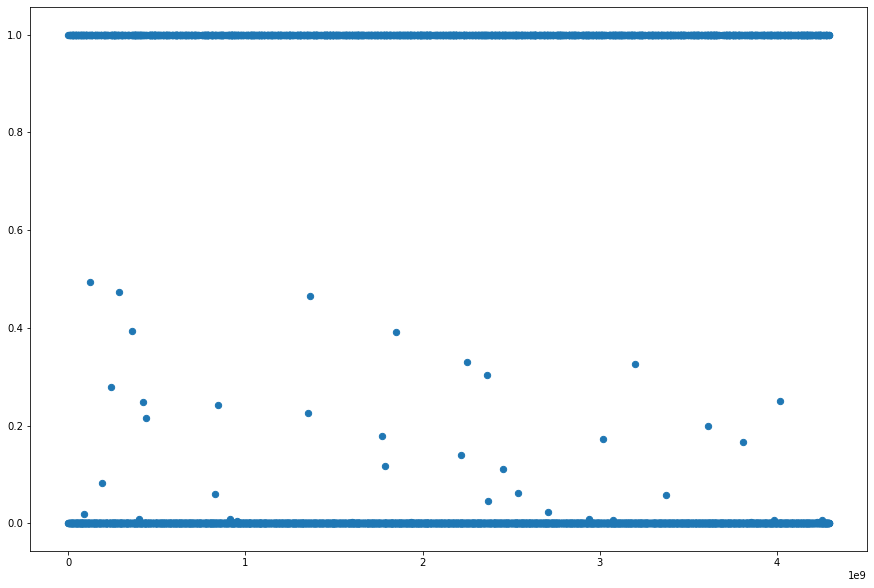

In [157]:
plt.figure(figsize=(15, 10))
plt.scatter(npAbnormalX, npAbnormalprob, s=40)
plt.show()

## 比特同步

### 构造建立模型
14个属性

In [116]:
class GANbit(object):
    def __init__(self):
        self.fn_makeGenerator()
        self.fn_makeDiscriminator()
        
    def fn_makeGenerator(self):
        self.oSeqGe = tf.keras.Sequential(name="Ge")
        self.oSeqGe.add(tf.keras.Input(shape=(14,)))
        self.oSeqGe.add(tf.keras.layers.Dense(10, kernel_initializer="he_normal"))
        self.oSeqGe.add(tf.keras.layers.LeakyReLU())
        self.oSeqGe.add(tf.keras.layers.BatchNormalization())
        self.oSeqGe.add(tf.keras.layers.Dense(10, kernel_initializer="he_normal"))
        self.oSeqGe.add(tf.keras.layers.LeakyReLU())

        self.oSeqGd = tf.keras.Sequential(name="Gd")
        self.oSeqGd.add(tf.keras.Input(shape=(10,)))
        self.oSeqGd.add(tf.keras.layers.Dense(10, kernel_initializer="he_normal"))
        self.oSeqGd.add(tf.keras.layers.LeakyReLU())
        self.oSeqGd.add(tf.keras.layers.BatchNormalization())
        self.oSeqGd.add(tf.keras.layers.Dense(14, activation = tf.keras.activations.tanh, kernel_initializer="he_normal"))
        
        self.oSeqGe1 = tf.keras.Sequential(name="Ge1")
        self.oSeqGe1.add(tf.keras.Input(shape=(14,)))
        self.oSeqGe1.add(tf.keras.layers.Dense(10, kernel_initializer="he_normal"))
        self.oSeqGe1.add(tf.keras.layers.LeakyReLU())
        self.oSeqGe1.add(tf.keras.layers.BatchNormalization())
        self.oSeqGe1.add(tf.keras.layers.Dense(10, kernel_initializer="he_normal"))
        self.oSeqGe1.add(tf.keras.layers.LeakyReLU())
        
    def fn_makeDiscriminator(self):
        self.oSeqDInner = tf.keras.Sequential(name="DInner")
        self.oSeqDInner.add(tf.keras.Input(shape=(14,)))
        self.oSeqDInner.add(tf.keras.layers.Dense(10, kernel_initializer="he_normal"))
        self.oSeqDInner.add(tf.keras.layers.LeakyReLU())
        self.oSeqDInner.add(tf.keras.layers.BatchNormalization())
        self.oSeqDInner.add(tf.keras.layers.Dense(10, kernel_initializer="he_normal"))
        self.oSeqDInner.add(tf.keras.layers.LeakyReLU())
        self.oSeqDInner.add(tf.keras.layers.BatchNormalization())

        self.oSeqD = tf.keras.Sequential([
            self.oSeqDInner,
            tf.keras.layers.Dense(1, activation = tf.keras.activations.sigmoid)
        ], name="D")

In [127]:
# 新建模型
tf.keras.backend.clear_session()
oGANbit = GANbit()

### 构造数据集

In [128]:
g_nFeatures = 14
g_nBatchSize = 256

def fn_splitCsvLine(strLine):
    tensorDefs = [0.] * g_nFeatures
    tensorRecord = tf.io.decode_csv(strLine, record_defaults=tensorDefs)
    tensorX = tf.stack(tensorRecord)
    return tensorX

oDataset = tf.data.Dataset.list_files(strJobsDir + "/*/*/parts/sync/bit/samples/normal/train/preprocessed/samples.csv")
oDataset = oDataset.interleave(lambda strSamplesFile: tf.data.TextLineDataset(strSamplesFile).skip(1), \
                              cycle_length=5, num_parallel_calls=5)
oDataset = oDataset.map(fn_splitCsvLine, g_nFeatures)
oDataset = oDataset.shuffle(1000)
oDataset = oDataset.batch(g_nBatchSize)

In [119]:
# 读入所有的训练样本，从而通过shape属性得到训练集大小，存入全局变量中
listPreprocessedNormalTrainingSamples = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strPreprocessedNormalTrainingSamplesFile = os.path.join(strDemodDir, \
                                                   "parts/sync/bit/samples/normal/train/preprocessed/samples.csv")
        pdDfPreprocessedNormalTrainingSamples = pd.read_csv(strPreprocessedNormalTrainingSamplesFile)
        listPreprocessedNormalTrainingSamples.append(pdDfPreprocessedNormalTrainingSamples)
pdDfPreprocessedNormalTrainingSamples = pd.concat(listPreprocessedNormalTrainingSamples)
g_tensorNormalTrainingSamples = tf.constant(pdDfPreprocessedNormalTrainingSamples.values, dtype=tf.float32)
g_nTrainingSize = len(g_tensorNormalTrainingSamples)

### 训练

In [129]:
# g_nTrainingSize在中频控制已经设置好了
g_nEpochs = 400
nSteps = g_nEpochs * g_nTrainingSize // g_nBatchSize
oExponentialDecay = tf.keras.optimizers.schedules.ExponentialDecay(1e-2, nSteps, 1e-1)
oOptimizerG = tf.keras.optimizers.Adam(learning_rate=oExponentialDecay)
oOptimizerD = tf.keras.optimizers.SGD(learning_rate=oExponentialDecay)

In [130]:
# 构造日志
strPrefix = datetime.datetime.now().strftime("%H_%M_%S")
strPrefix = "{}".format("(14,10)_400Epoch")
oSummaryWriterDLoss = tf.summary.create_file_writer("logs/notest/sync/bit/" + strPrefix + "_D")
oSummaryWriterALoss = tf.summary.create_file_writer("logs/notest/sync/bit/" + strPrefix + "_A")

In [131]:
oSeqGe, oSeqGd, oSeqGe1 = fn_train(oGANbit)

2020-03-01 18:09:39.418676
399/400

In [132]:
oSeqGe.save("models/notest/sync/bit/Ge(14,10).h5")
oSeqGd.save("models/notest/sync/bit/Gd(14,10).h5")
oSeqGe1.save("models/notest/sync/bit/Ge1(14,10).h5")

### 评估

In [158]:
oSeqGe = tf.keras.models.load_model("models/notest/sync/bit/Ge(14,10).h5")
oSeqGd = tf.keras.models.load_model("models/notest/sync/bit/Gd(14,10).h5")
oSeqGe1 = tf.keras.models.load_model("models/notest/sync/bit/Ge1(14,10).h5")

In [159]:
# 算出正常训练集和异常测试集的分数
# train samples
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        strSamplesDir = os.path.join(strDemodDir, "parts/sync/bit/samples/normal/train")
        pdDfPreprocessedSamples = pd.read_csv(\
              os.path.join(strSamplesDir, "preprocessed/samples.csv"))
        pdDfSamples = pd.read_csv(os.path.join(strSamplesDir, "samples.csv"), index_col="RECTIME")
        # 分数csv包含scores列
        pdDfScores = fn_score(pdDfPreprocessedSamples)
        pdDfScores.index = pdDfSamples.index

        pdDfScores.to_csv(os.path.join(strSamplesDir, "preprocessed/scores.csv"), index_label="RECTIME")
        
# Abnormal samples
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        strSamplesDir = os.path.join(strDemodDir, "parts/sync/bit/samples/abnormal")
        pdDfPreprocessedSamples = pd.read_csv(os.path.join(strSamplesDir, "preprocessed/samples.csv"), index_col="RECTIME")
        pdDfScores = fn_score(pdDfPreprocessedSamples)

        pdDfScores.to_csv(os.path.join(strSamplesDir, "preprocessed/scores.csv"), index_label="RECTIME")

In [160]:
# 读入正常测试样本和异常测试样本的分数，分别存入numpy数组
listScores = []
listX = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strNormalTestingScoresFile = os.path.join(strDemodDir, \
                                                  "parts/sync/bit/samples/normal/train/preprocessed/scores.csv")
        pdDfNormalTestingScores = pd.read_csv(strNormalTestingScoresFile, index_col="RECTIME")
        
        if not pdDfNormalTestingScores.empty:
            listScores.append(pdDfNormalTestingScores["score"].values)
            
            # 分数的横坐标——用crc编码“解调器名+上报时间”
            strDemod = os.path.split(strDemodDir)[1]
            listX.append([crc32(str.encode(strDemod + strIndex)) for strIndex in pdDfNormalTestingScores.index])
            
npNormalScores = np.concatenate(listScores)
npNormalX = np.concatenate(listX)

In [161]:
listScores = []
listX = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strAbnormalTestingScoresFile = os.path.join(strDemodDir, \
                                                  "parts/sync/bit/samples/abnormal/preprocessed/scores.csv")
        pdDfAbnormalTestingScores = pd.read_csv(strAbnormalTestingScoresFile, index_col="RECTIME")
        if not pdDfAbnormalTestingScores.empty:
            listScores.append(pdDfAbnormalTestingScores["score"].values)
            
             # 分数的横坐标——用crc编码“解调器名+上报时间”
            strDemod = os.path.split(strDemodDir)[1]
            listX.append([crc32(str.encode(strDemod + strIndex)) for strIndex in pdDfAbnormalTestingScores.index])
            
npAbnormalScores = np.concatenate(listScores)
npAbnormalX = np.concatenate(listX)

In [162]:
"""
通过正常训练样本的分数计算相应的正太分布，利用正态分布计算异常样本该部分正确的概率
"""
fMeanbit = np.mean(npNormalScores)
fSigmabit = np.var(npNormalScores)
npAbnormalprob = np.apply_along_axis(lambda x: 1 if x <= fMeanbit else ss.norm.sf(x, fMeanbit, fSigmabit), 1, \
     npAbnormalScores[:, np.newaxis])

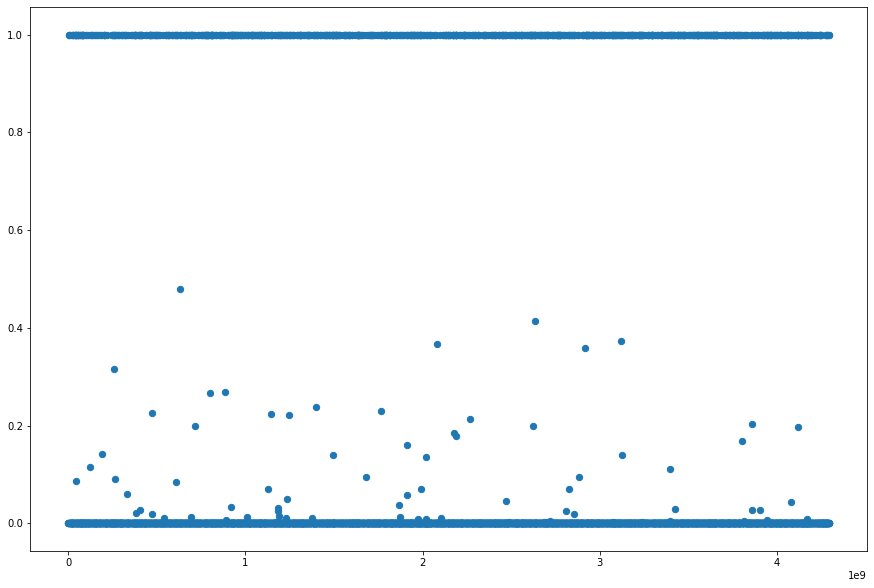

In [163]:
plt.figure(figsize=(15, 10))
plt.scatter(npAbnormalX, npAbnormalprob, s=40)
plt.show()

## 维特比译码

### 构造建立模型
18个属性

In [140]:
class GANvi(object):
    def __init__(self):
        self.fn_makeGenerator()
        self.fn_makeDiscriminator()
        
    def fn_makeGenerator(self):
        self.oSeqGe = tf.keras.Sequential(name="Ge")
        self.oSeqGe.add(tf.keras.Input(shape=(18,)))
        self.oSeqGe.add(tf.keras.layers.Dense(14, kernel_initializer="he_normal"))
        self.oSeqGe.add(tf.keras.layers.LeakyReLU())
        self.oSeqGe.add(tf.keras.layers.BatchNormalization())
        self.oSeqGe.add(tf.keras.layers.Dense(14, kernel_initializer="he_normal"))
        self.oSeqGe.add(tf.keras.layers.LeakyReLU())

        self.oSeqGd = tf.keras.Sequential(name="Gd")
        self.oSeqGd.add(tf.keras.Input(shape=(14,)))
        self.oSeqGd.add(tf.keras.layers.Dense(14, kernel_initializer="he_normal"))
        self.oSeqGd.add(tf.keras.layers.LeakyReLU())
        self.oSeqGd.add(tf.keras.layers.BatchNormalization())
        self.oSeqGd.add(tf.keras.layers.Dense(18, activation = tf.keras.activations.tanh, kernel_initializer="he_normal"))
        
        self.oSeqGe1 = tf.keras.Sequential(name="Ge1")
        self.oSeqGe1.add(tf.keras.Input(shape=(18,)))
        self.oSeqGe1.add(tf.keras.layers.Dense(14, kernel_initializer="he_normal"))
        self.oSeqGe1.add(tf.keras.layers.LeakyReLU())
        self.oSeqGe1.add(tf.keras.layers.BatchNormalization())
        self.oSeqGe1.add(tf.keras.layers.Dense(14, kernel_initializer="he_normal"))
        self.oSeqGe1.add(tf.keras.layers.LeakyReLU())
        
    def fn_makeDiscriminator(self):
        self.oSeqDInner = tf.keras.Sequential(name="DInner")
        self.oSeqDInner.add(tf.keras.Input(shape=(18,)))
        self.oSeqDInner.add(tf.keras.layers.Dense(14, kernel_initializer="he_normal"))
        self.oSeqDInner.add(tf.keras.layers.LeakyReLU())
        self.oSeqDInner.add(tf.keras.layers.BatchNormalization())
        self.oSeqDInner.add(tf.keras.layers.Dense(14, kernel_initializer="he_normal"))
        self.oSeqDInner.add(tf.keras.layers.LeakyReLU())
        self.oSeqDInner.add(tf.keras.layers.BatchNormalization())

        self.oSeqD = tf.keras.Sequential([
            self.oSeqDInner,
            tf.keras.layers.Dense(1, activation = tf.keras.activations.sigmoid)
        ], name="D")

In [141]:
# 新建模型
tf.keras.backend.clear_session()
oGANvi = GANvi()

### 构造数据集

In [142]:
g_nFeatures = 18
g_nBatchSize = 256

def fn_splitCsvLine(strLine):
    tensorDefs = [0.] * g_nFeatures
    tensorRecord = tf.io.decode_csv(strLine, record_defaults=tensorDefs)
    tensorX = tf.stack(tensorRecord)
    return tensorX

oDataset = tf.data.Dataset.list_files(strJobsDir + "/*/*/parts/sync/vi/*/samples/normal/train/preprocessed/samples.csv")
oDataset = oDataset.interleave(lambda strSamplesFile: tf.data.TextLineDataset(strSamplesFile).skip(1), \
                              cycle_length=5, num_parallel_calls=5)
oDataset = oDataset.map(fn_splitCsvLine, g_nFeatures)
oDataset = oDataset.shuffle(1000)
oDataset = oDataset.batch(g_nBatchSize)

In [143]:
# 读入所有的训练样本，从而通过shape属性得到训练集大小，存入全局变量中
# 由于对于分路情况，有I和Q两路样本，所以两路都要读
listPreprocessedNormalTrainingSamples = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        # 读入控制文件，方便判断合路、分路 
        pdDfControl = pd.read_csv(os.path.join(strDemodDir, "control.csv"), index_col="RECTIME")
        # 设置部分的文件夹
        strSectionDir = os.path.join(strDemodDir, "parts/sync/vi")
        
        # 用dataframe的numpy值存入链表，再收尾连接。因为I和Q的属性名称的后缀不同，直接连接会出现Nan
        if pdDfControl["DEMOD_FRAMESYNCINPUT"][0] == 1:
            # 合路
            listPreprocessedNormalTrainingSamples.append(\
                 pd.read_csv(os.path.join(strSectionDir, "I/samples/normal/train/preprocessed/samples.csv")).values)
        else:
            # 分路
            listPreprocessedNormalTrainingSamples.append(\
                 pd.read_csv(os.path.join(strSectionDir, "I/samples/normal/train/preprocessed/samples.csv")).values)
            listPreprocessedNormalTrainingSamples.append(\
                 pd.read_csv(os.path.join(strSectionDir, "Q/samples/normal/train/preprocessed/samples.csv")).values)
pdDfPreprocessedNormalTrainingSamples = np.concatenate(listPreprocessedNormalTrainingSamples)
g_tensorNormalTrainingSamples = tf.constant(pdDfPreprocessedNormalTrainingSamples, dtype=tf.float32)
g_nTrainingSize = len(g_tensorNormalTrainingSamples)

### 训练

In [144]:
# g_nTrainingSize在中频控制已经设置好了
# 存储生成器的解码器和译码器
oSeqGe = None
oSeqGd = None
oSeqGe1 = None

g_nEpochs = 400
g_nStep = 
nSteps = g_nEpochs * g_nTrainingSize // g_nBatchSize
oExponentialDecay = tf.keras.optimizers.schedules.ExponentialDecay(1e-2, nSteps, 1e-1)
oOptimizerG = tf.keras.optimizers.Adam(learning_rate=oExponentialDecay)
oOptimizerD = tf.keras.optimizers.SGD(learning_rate=oExponentialDecay)

In [145]:
# 构造日志
strPrefix = datetime.datetime.now().strftime("%H_%M_%S")
strPrefix = "{}".format((18,14,400))
oSummaryWriterDLoss = tf.summary.create_file_writer("logs/notest/sync/vi/" + strPrefix + "_D")
oSummaryWriterALoss = tf.summary.create_file_writer("logs/notest/sync/vi/" + strPrefix + "_A")

In [146]:
fn_train(oGANvi)

2020-03-01 19:10:53.608763
399/400

In [148]:
oSeqGe.save("models/notest/sync/vi/Ge(18,14,400).h5")
oSeqGd.save("models/notest/sync/vi/Gd(18,14,400).h5")
oSeqGe1.save("models/notest/sync/vi/Ge1(18,14,400).h5")

### 评估

In [164]:
oSeqGe = tf.keras.models.load_model("models/notest/sync/vi/Ge(18,14,400).h5")
oSeqGd = tf.keras.models.load_model("models/notest/sync/vi/Gd(18,14,400).h5")
oSeqGe1 = tf.keras.models.load_model("models/notest/sync/vi/Ge1(18,14,400).h5")

In [165]:
# 计算分数
def fn_scoresIOrQ():
    # train samples
    pdDfPreprocessedSamples = pd.read_csv(\
          os.path.join(strSamplesDir, "normal/train/preprocessed/samples.csv"))
    # 分数csv包含scores列
    pdDfScores = fn_score(pdDfPreprocessedSamples)
    
    pdDfSamples = pd.read_csv(os.path.join(strSamplesDir, "normal/train/samples.csv"), index_col="RECTIME")
    pdDfScores.index = pdDfSamples.index
    pdDfScores.to_csv(os.path.join(strSamplesDir, "normal/train/preprocessed/scores.csv"), index_label="RECTIME")

    # Abnormal samples
    pdDfPreprocessedSamples = pd.read_csv(\
          os.path.join(strSamplesDir, "abnormal/preprocessed/samples.csv"), index_col="RECTIME")
    pdDfScores = fn_score(pdDfPreprocessedSamples)
    pdDfScores.to_csv(os.path.join(strSamplesDir, "abnormal/preprocessed/scores.csv"), index_label="RECTIME")

for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        strSectionDir = os.path.join(strDemodDir, "parts/sync/vi")
        # 读入控制文件
        pdDfControl = pd.read_csv(os.path.join(strDemodDir, "control.csv"), index_col="RECTIME")
        
        if pdDfControl["DEMOD_FRAMESYNCINPUT"][0] == 1:
            #合路
            strSamplesDir = os.path.join(strSectionDir, "I/samples")
            fn_scoresIOrQ()
        else:
            # 分路
            strSamplesDir = os.path.join(strSectionDir, "I/samples")
            fn_scoresIOrQ()
            strSamplesDir = os.path.join(strSectionDir, "Q/samples")
            fn_scoresIOrQ()

In [170]:
# 读取正常训练样本分数
# 需要读入每个分路正常训练样本的I路和Q路的分数，用于计算阈值
listScores = []
listX = []
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        pdDfControl = pd.read_csv(os.path.join(strDemodDir, "control.csv"), index_col="RECTIME")
        strSectionDir = os.path.join(strDemodDir, "parts/sync/vi")
        
        strDemod = os.path.split(strDemodDir)[1]
        if pdDfControl["DEMOD_FRAMESYNCINPUT"][0] == 1:
            # 合路
            pdDfNormalTrainingScores = pd.read_csv(os.path.join(strSectionDir, \
               "I/samples/normal/train/preprocessed/scores.csv"), index_col="RECTIME")
            listScores.append(pdDfNormalTrainingScores["score"].values)
            listX.append([crc32(str.encode(strDemod + strIndex)) for strIndex in pdDfNormalTrainingScores.index])
        else:
            # 合路
            pdDfNormalTrainingScores = pd.read_csv(os.path.join(strSectionDir, \
               "I/samples/normal/train/preprocessed/scores.csv"), index_col="RECTIME")
            listScores.append(pdDfNormalTrainingScores["score"].values)
            listX.append([crc32(str.encode(strDemod + strIndex)) for strIndex in pdDfNormalTrainingScores.index])
            
            pdDfNormalTrainingScores = pd.read_csv(os.path.join(strSectionDir, \
               "Q/samples/normal/train/preprocessed/scores.csv"), index_col="RECTIME")
            listScores.append(pdDfNormalTrainingScores["score"].values)
            listX.append([crc32(str.encode(strDemod + strIndex)) for strIndex in pdDfNormalTrainingScores.index])
npNormalScores = np.concatenate(listScores)
npNormalX = np.concatenate(listX)

In [171]:
# 读取异常测试样本分数
# 只需要读入I路的分数
listScores = []
listX = []
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        pdDfControl = pd.read_csv(os.path.join(strDemodDir, "control.csv"), index_col="RECTIME")
        strSectionDir = os.path.join(strDemodDir, "parts/sync/vi")
        
        strDemod = os.path.split(strDemodDir)[1]
        pdDfAbnormalTestingScores = pd.read_csv(os.path.join(strSectionDir, \
           "I/samples/abnormal/preprocessed/scores.csv"), index_col="RECTIME")
        listScores.append(pdDfAbnormalTestingScores["score"].values)
        listX.append([crc32(str.encode(strDemod + strIndex)) for strIndex in pdDfAbnormalTestingScores.index])
npAbnormalScores = np.concatenate(listScores)
npAbnormalX = np.concatenate(listX)

In [172]:
"""
通过正常训练样本的分数计算相应的正太分布，利用正态分布计算异常样本该部分正确的概率
"""
fMeanvi = np.mean(npNormalScores)
fSigmavi = np.var(npNormalScores)
npAbnormalprob = np.apply_along_axis(lambda x: 1 if x <= fMeanvi else ss.norm.sf(x, fMeanvi, fSigmavi), 1, \
     npAbnormalScores[:, np.newaxis].astype(np.float64))

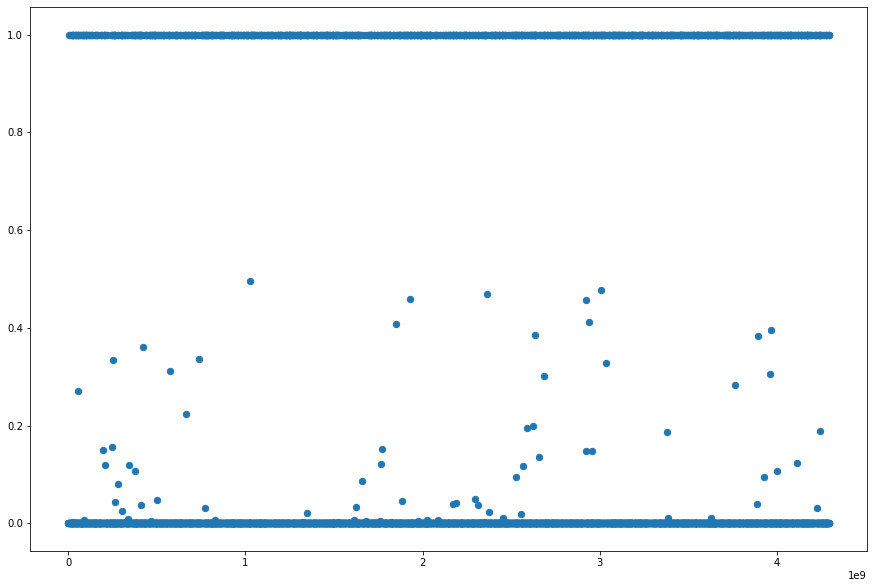

In [173]:
plt.figure(figsize=(15, 10))
plt.scatter(npAbnormalX, npAbnormalprob, s=40)
plt.show()

## 帧同步

### 构造建立模型
24个属性

In [168]:
class GANframe(object):
    def __init__(self):
        self.fn_makeGenerator()
        self.fn_makeDiscriminator()
        
    def fn_makeGenerator(self):
        self.oSeqGe = tf.keras.Sequential(name="Ge")
        self.oSeqGe.add(tf.keras.Input(shape=(24,)))
        self.oSeqGe.add(tf.keras.layers.Dense(22, kernel_initializer="he_normal"))
        self.oSeqGe.add(tf.keras.layers.LeakyReLU())
        self.oSeqGe.add(tf.keras.layers.BatchNormalization())
        self.oSeqGe.add(tf.keras.layers.Dense(22, kernel_initializer="he_normal"))
        self.oSeqGe.add(tf.keras.layers.LeakyReLU())

        self.oSeqGd = tf.keras.Sequential(name="Gd")
        self.oSeqGd.add(tf.keras.Input(shape=(22,)))
        self.oSeqGd.add(tf.keras.layers.Dense(22, kernel_initializer="he_normal"))
        self.oSeqGd.add(tf.keras.layers.LeakyReLU())
        self.oSeqGd.add(tf.keras.layers.BatchNormalization())
        self.oSeqGd.add(tf.keras.layers.Dense(24, activation = tf.keras.activations.tanh, kernel_initializer="he_normal"))
        
        self.oSeqGe1 = tf.keras.Sequential(name="Ge1")
        self.oSeqGe1.add(tf.keras.Input(shape=(24,)))
        self.oSeqGe1.add(tf.keras.layers.Dense(22, kernel_initializer="he_normal"))
        self.oSeqGe1.add(tf.keras.layers.LeakyReLU())
        self.oSeqGe1.add(tf.keras.layers.BatchNormalization())
        self.oSeqGe1.add(tf.keras.layers.Dense(22, kernel_initializer="he_normal"))
        self.oSeqGe1.add(tf.keras.layers.LeakyReLU())
        
    def fn_makeDiscriminator(self):
        self.oSeqDInner = tf.keras.Sequential(name="DInner")
        self.oSeqDInner.add(tf.keras.Input(shape=(24,)))
        self.oSeqDInner.add(tf.keras.layers.Dense(22, kernel_initializer="he_normal"))
        self.oSeqDInner.add(tf.keras.layers.LeakyReLU())
        self.oSeqDInner.add(tf.keras.layers.BatchNormalization())
        self.oSeqDInner.add(tf.keras.layers.Dense(22, kernel_initializer="he_normal"))
        self.oSeqDInner.add(tf.keras.layers.LeakyReLU())
        self.oSeqDInner.add(tf.keras.layers.BatchNormalization())

        self.oSeqD = tf.keras.Sequential([
            self.oSeqDInner,
            tf.keras.layers.Dense(1, activation = tf.keras.activations.sigmoid)
        ], name="D")

In [180]:
# 新建模型
tf.keras.backend.clear_session()
oGAN = GANframe()

### 构造数据集

In [170]:
g_nFeatures = 24
g_nBatchSize = 256

def fn_splitCsvLine(strLine):
    tensorDefs = [0.] * g_nFeatures
    tensorRecord = tf.io.decode_csv(strLine, record_defaults=tensorDefs)
    tensorX = tf.stack(tensorRecord)
    return tensorX

oDataset = tf.data.Dataset.list_files(strJobsDir + "/*/*/parts/sync/frame/*/samples/normal/train/preprocessed/samples.csv")
oDataset = oDataset.interleave(lambda strSamplesFile: tf.data.TextLineDataset(strSamplesFile).skip(1), \
                              cycle_length=5, num_parallel_calls=5)
oDataset = oDataset.map(fn_splitCsvLine, g_nFeatures)
oDataset = oDataset.shuffle(1000)
oDataset = oDataset.batch(g_nBatchSize)

In [171]:
# 读入所有的训练样本，从而通过shape属性得到训练集大小，存入全局变量中，并且要用于每次迭代结束后计算总的损失，从而求得最佳模型
# 由于对于分路情况，有I和Q两路样本，所以两路都要读
listPreprocessedNormalTrainingSamples = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        # 读入控制文件，方便判断合路、分路 
        pdDfControl = pd.read_csv(os.path.join(strDemodDir, "control.csv"), index_col="RECTIME")
        # 设置部分的文件夹
        strSectionDir = os.path.join(strDemodDir, "parts/sync/frame")
        
        # 用dataframe的numpy值存入链表，再收尾连接。因为I和Q的属性名称的后缀不同，直接连接会出现Nan
        if pdDfControl["DEMOD_FRAMESYNCINPUT"][0] == 1:
            # 合路
            listPreprocessedNormalTrainingSamples.append(\
                 pd.read_csv(os.path.join(strSectionDir, "I/samples/normal/train/preprocessed/samples.csv")).values)
        else:
            # 分路
            listPreprocessedNormalTrainingSamples.append(\
                 pd.read_csv(os.path.join(strSectionDir, "I/samples/normal/train/preprocessed/samples.csv")).values)
            listPreprocessedNormalTrainingSamples.append(\
                 pd.read_csv(os.path.join(strSectionDir, "Q/samples/normal/train/preprocessed/samples.csv")).values)
pdDfPreprocessedNormalTrainingSamples = np.concatenate(listPreprocessedNormalTrainingSamples)
g_tensorNormalTrainingSamples = tf.constant(pdDfPreprocessedNormalTrainingSamples, dtype=tf.float32)
g_nTrainingSize = len(g_tensorNormalTrainingSamples)

### 训练

In [181]:
# g_nTrainingSize在中频控制已经设置好了
# 存储生成器的解码器和译码器
oSeqGe = None
oSeqGd = None
oSeqGe1 = None

g_nEpochs = 1000
g_nStep = 0
nSteps = g_nEpochs * g_nTrainingSize // g_nBatchSize
oExponentialDecay = tf.keras.optimizers.schedules.ExponentialDecay(1e-2, nSteps, 1e-1)
oOptimizerG = tf.keras.optimizers.Adam(learning_rate=oExponentialDecay)
oOptimizerD = tf.keras.optimizers.SGD(learning_rate=oExponentialDecay)

In [173]:
# 构造日志
strPrefix = datetime.datetime.now().strftime("%H_%M_%S")
strPrefix = "{}".format("(24,22,1000)")
oSummaryWriterDLoss = tf.summary.create_file_writer("logs/notest/sync/frame/" + strPrefix + "_D")
oSummaryWriterALoss = tf.summary.create_file_writer("logs/notest/sync/frame/" + strPrefix + "_A")

In [182]:
# 开始训练

def fn_getGLoss(tensorInput):
    # Apperant loss
    tensorEncodedSamples = oGAN.oSeqGe(tensorInput)
    tensorFakeSamples = oGAN.oSeqGd(tensorEncodedSamples)
    tensorApperantLoss = tf.reduce_mean(tf.losses.mean_absolute_error(tensorInput, tensorFakeSamples))

    # Latent loss
    tensorEncoded1Samples = oGAN.oSeqGe1(tensorFakeSamples)
    tensorLatentLoss = \
    tf.reduce_mean(tf.losses.mean_squared_error(tensorEncodedSamples, tensorEncoded1Samples))

    # Feature matching loss
    tensorPredFeatures = oGAN.oSeqDInner(tensorFakeSamples)
    tensorTrueFeatures = oGAN.oSeqDInner(tensorInput)
    tensorFeatureLoss = tf.reduce_mean(tf.losses.mean_squared_error(tensorPredFeatures, tensorTrueFeatures))

    tensorGLoss = tensorApperantLoss + tensorLatentLoss + tensorFeatureLoss
    return tensorGLoss

# 在每个epoch后存储最小的ALoss和对应的
fGLossLast = np.inf
# 开始训练，输出训练的开始时间和训练的结束时间
print(datetime.datetime.now())
for nEpoch in range(g_nEpochs):
    for tensorBatch in oDataset:
        # Train discriminator
        # Generator fake samples
        tensorEncodedSamples = oGAN.oSeqGe(tensorBatch)
        tensorFakeSamples = oGAN.oSeqGd(tensorEncodedSamples)
        with tf.GradientTape() as oGradientTapeD:
            # Train discriminator with real samples
            tensorLabels = tf.random.uniform(minval=0.7, maxval=1.2, seed=42, shape=(tensorBatch.shape[0], 1))
            tensorPreds = oGAN.oSeqD(tensorBatch)
            tensorDLossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(tensorLabels, tensorPreds))
        listDGradients = oGradientTapeD.gradient(tensorDLossR, oGAN.oSeqD.trainable_variables)
        oOptimizerD.apply_gradients(zip(listDGradients, oGAN.oSeqD.trainable_variables))
        with tf.GradientTape() as oGradientTapeD:
            # Train discriminator with fake samples
            tensorLabels = tf.random.uniform(minval=0., maxval=0.3, seed = 42, shape=(tensorFakeSamples.shape[0], 1))
            tensorPreds = oGAN.oSeqD(tensorFakeSamples)
            tensorDLossF = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(tensorLabels, tensorPreds))
        listDGradients = oGradientTapeD.gradient(tensorDLossF, oGAN.oSeqD.trainable_variables)
        oOptimizerD.apply_gradients(zip(listDGradients, oGAN.oSeqD.trainable_variables))
        tensorDLoss = tensorDLossR + tensorDLossF
        with oSummaryWriterDLoss.as_default():
            tf.summary.scalar("D_Loss", tensorDLoss, g_nStep)

        # Train genertor
        with tf.GradientTape() as oGradientTapeG:
            tensorGLoss = fn_getGLoss(tensorBatch)
        # Insert all generator trainable variables into a list
        listTrainableGVariables = []
        listTrainableGVariables.extend(oGAN.oSeqGe.trainable_variables)
        listTrainableGVariables.extend(oGAN.oSeqGd.trainable_variables)
        listTrainableGVariables.extend(oGAN.oSeqGe1.trainable_variables)

        listGGradients = oGradientTapeG.gradient(tensorGLoss, listTrainableGVariables)
        oOptimizerG.apply_gradients(zip(listGGradients, listTrainableGVariables))
        with oSummaryWriterALoss.as_default():
            tf.summary.scalar("A_loss", tensorGLoss, g_nStep)

        g_nStep = g_nStep + 1

    # 在整个训练集上计算generator的损失，并比较和上一次迭代的损失，如果小于上一次迭代，更新损失和最有模型；反之停止训练
    tensorGLossOverTotalSamples = fn_getGLoss(g_tensorNormalTrainingSamples)
    if fGLossLast > tensorGLossOverTotalSamples.numpy():
        fGLossLast = tensorGLossOverTotalSamples.numpy()
        oSeqGe = oGAN.oSeqGe
        oSeqGd = oGAN.oSeqGd
        oSeqGe1 = oGAN.oSeqGe1
    # 输出进度
    fn_printBar(nEpoch)
print(datetime.datetime.now())

2020-03-01 21:03:41.616103
238/1000

KeyboardInterrupt: 

In [184]:
oSeqGe.save("models/notest/sync/frame/Ge(24,22).h5")
oSeqGd.save("models/notest/sync/frame/Gd(24,22).h5")
oSeqGe1.save("models/notest/sync/frame/Ge1(24,22).h5")

### 评估

In [168]:
oSeqGe = tf.keras.models.load_model("models/notest/sync/frame/Ge(24,22).h5")
oSeqGd = tf.keras.models.load_model("models/notest/sync/frame/Gd(24,22).h5")
oSeqGe1 = tf.keras.models.load_model("models/notest/sync/frame/Ge1(24,22).h5")

In [169]:
# 计算分数
def fn_scoresIOrQ():
    # train samples
    pdDfPreprocessedSamples = pd.read_csv(\
          os.path.join(strSamplesDir, "normal/train/preprocessed/samples.csv"))
    # 分数csv包含scores列
    pdDfScores = fn_score(pdDfPreprocessedSamples)
    
    pdDfSamples = pd.read_csv(os.path.join(strSamplesDir, "normal/train/samples.csv"), index_col="RECTIME")
    pdDfScores.index = pdDfSamples.index
    pdDfScores.to_csv(os.path.join(strSamplesDir, "normal/train/preprocessed/scores.csv"), index_label="RECTIME")

    # Abnormal samples
    pdDfPreprocessedSamples = pd.read_csv(\
          os.path.join(strSamplesDir, "abnormal/preprocessed/samples.csv"), index_col="RECTIME")
    pdDfScores = fn_score(pdDfPreprocessedSamples)
    pdDfScores.to_csv(os.path.join(strSamplesDir, "abnormal/preprocessed/scores.csv"), index_label="RECTIME")

for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        strSectionDir = os.path.join(strDemodDir, "parts/sync/frame")
        # 读入控制文件
        pdDfControl = pd.read_csv(os.path.join(strDemodDir, "control.csv"), index_col="RECTIME")
        
        if pdDfControl["DEMOD_FRAMESYNCINPUT"][0] == 1:
            #合路
            strSamplesDir = os.path.join(strSectionDir, "I/samples")
            fn_scoresIOrQ()
        else:
            # 分路
            strSamplesDir = os.path.join(strSectionDir, "I/samples")
            fn_scoresIOrQ()
            strSamplesDir = os.path.join(strSectionDir, "Q/samples")
            fn_scoresIOrQ()

In [174]:
# 读取正常训练样本分数
# 需要读入每个分路正常训练样本的I路和Q路的分数，用于计算阈值
listScores = []
listX = []
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        pdDfControl = pd.read_csv(os.path.join(strDemodDir, "control.csv"), index_col="RECTIME")
        strSectionDir = os.path.join(strDemodDir, "parts/sync/frame")
        
        strDemod = os.path.split(strDemodDir)[1]
        if pdDfControl["DEMOD_FRAMESYNCINPUT"][0] == 1:
            # 合路
            pdDfNormalTrainingScores = pd.read_csv(os.path.join(strSectionDir, \
               "I/samples/normal/train/preprocessed/scores.csv"), index_col="RECTIME")
            listScores.append(pdDfNormalTrainingScores["score"].values)
            listX.append([crc32(str.encode(strDemod + strIndex)) for strIndex in pdDfNormalTrainingScores.index])
        else:
            # 合路
            pdDfNormalTrainingScores = pd.read_csv(os.path.join(strSectionDir, \
               "I/samples/normal/train/preprocessed/scores.csv"), index_col="RECTIME")
            listScores.append(pdDfNormalTrainingScores["score"].values)
            listX.append([crc32(str.encode(strDemod + strIndex)) for strIndex in pdDfNormalTrainingScores.index])
            
            pdDfNormalTrainingScores = pd.read_csv(os.path.join(strSectionDir, \
               "Q/samples/normal/train/preprocessed/scores.csv"), index_col="RECTIME")
            listScores.append(pdDfNormalTrainingScores["score"].values)
            listX.append([crc32(str.encode(strDemod + strIndex)) for strIndex in pdDfNormalTrainingScores.index])
npNormalScores = np.concatenate(listScores)
npNormalX = np.concatenate(listX)

In [175]:
# 读取异常测试样本分数
# 只需要读入I路的分数
listScores = []
listX = []
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        pdDfControl = pd.read_csv(os.path.join(strDemodDir, "control.csv"), index_col="RECTIME")
        strSectionDir = os.path.join(strDemodDir, "parts/sync/frame")
        
        strDemod = os.path.split(strDemodDir)[1]
        pdDfAbnormalTestingScores = pd.read_csv(os.path.join(strSectionDir, \
           "I/samples/abnormal/preprocessed/scores.csv"), index_col="RECTIME")
        listScores.append(pdDfAbnormalTestingScores["score"].values)
        listX.append([crc32(str.encode(strDemod + strIndex)) for strIndex in pdDfAbnormalTestingScores.index])
npAbnormalScores = np.concatenate(listScores)
npAbnormalX = np.concatenate(listX)

In [176]:
"""
通过正常训练样本的分数计算相应的正太分布，利用正态分布计算异常样本该部分正确的概率
"""
fMeanframe = np.mean(npNormalScores)
fSigmaframe = np.var(npNormalScores)
npAbnormalprob = np.apply_along_axis(lambda x: 1 if x <= fMeanframe else ss.norm.sf(x, fMeanframe, fSigmaframe), 1, \
     npAbnormalScores[:, np.newaxis].astype(np.float64))

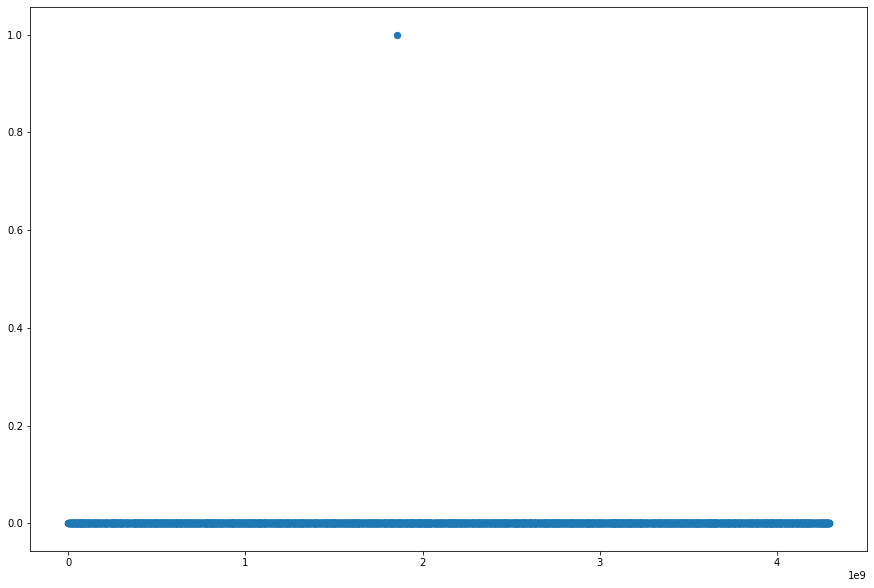

In [177]:
plt.figure(figsize=(15, 10))
plt.scatter(npAbnormalX, npAbnormalprob, s=40)
plt.show()

## 计算正确率并存入json
将每一个异常样本存入一个json文件中，文件名为“任务名&解调器名&时间点.json”。

json结构如下：
* “中频控制”元组
    * 各个参数名及对应的参数值
    * 正确率
* “中频输入”元组
* “载波同步”元组
* “比特同步”元组
* “维特比译码”元组
* “帧同步”元组

In [280]:
"""
分路之前的各个部分对应的异常样本相同，分路之后的异常样本可能相比于分路之前的有所增加。
以分路之前的各个部分的异常样本index为准，寻找其对应的记录在分路之后各个部分的原始参数值
将每个记录各个阶段的参数键值对存入以该部分的名称为名的字典中，并在最后附加上该部分的正确率
最终
"""
dictScores = {"中频控制": [], "中频输入": [], "载波同步": [], "比特同步": [], "维特比译码": [], "帧同步": []}
dictIds = []
dictValues = {"中频控制": [], "中频输入": [], "载波同步": [], "比特同步": [], "维特比译码": [], "帧同步": []}

def fn_combiner(strSection):
    dictScores[strSection].append(pdDfScores.values[:, 0])
    dictValues[strSection].extend([dict(zip(pdDfSamples.columns, pdDfSamples.loc[strIndex, :])) 
         for strIndex in pdDfSamples.index])
    
def fn_separate(strSection, listFeatures):
    dictScores[strSection].append(pdDfScores.values[:, 0])
    dictValues[strSection].extend([dict(zip(listFeatures, pdDfSamples.loc[strIndex, listFeatures])) 
         for strIndex in pdDfSamples.index])

for strJob in os.listdir(strJobsDir):
    for strDemodDir in fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob)):
        strDemod = os.path.split(strDemodDir)[1]
        strPartDir = os.path.join(strDemodDir, "parts/sync")
        """中频控制"""
        pdDfScores = pd.read_csv(os.path.join(strPartDir, "ifu/samples/abnormal/preprocessed/scores.csv"), \
            index_col="RECTIME")
        pdDfSamples = pd.read_csv(os.path.join(strPartDir, "ifu/samples/abnormal/samples.csv"), index_col="RECTIME")
        fn_combiner("中频控制")
        oIndex = pdDfScores.index
        dictIds.extend([strJob + "&" + strDemod + "&" + strIndex[-8:].replace(":", "_") for strIndex in oIndex])


        """中频输入"""
        pdDfScores = pd.read_csv(os.path.join(strPartDir, "input/samples/abnormal/preprocessed/scores.csv"), \
            index_col="RECTIME")
        pdDfSamples = pd.read_csv(os.path.join(strPartDir, "input/samples/abnormal/samples.csv"), index_col="RECTIME")
        fn_combiner("中频输入")

        """载波同步"""
        pdDfScores = pd.read_csv(os.path.join(strPartDir, "carrier/samples/abnormal/preprocessed/scores.csv"), \
            index_col="RECTIME")
        pdDfSamples = pd.read_csv(os.path.join(strPartDir, "carrier/samples/abnormal/samples.csv"), index_col="RECTIME")
        fn_combiner("载波同步")

        """比特同步"""
        pdDfScores = pd.read_csv(os.path.join(strPartDir, "bit/samples/abnormal/preprocessed/scores.csv"), \
             index_col="RECTIME")
        pdDfSamples = pd.read_csv(os.path.join(strPartDir, "bit/samples/abnormal/samples.csv"), index_col="RECTIME")
        fn_combiner("比特同步")

        """只读入I路"""
        """维特比译码"""
        pdDfScores = pd.read_csv(os.path.join(strPartDir, "vi/I/samples/abnormal/preprocessed/scores.csv"), \
             index_col="RECTIME").loc[oIndex, :]
        pdDfSamples = pd.read_csv(os.path.join(strPartDir, "vi/I/samples/abnormal/samples.csv"), \
              index_col="RECTIME").loc[oIndex, :]
        fn_separate("维特比译码", ["DEMOD_VITERBIINPUT", "DEMOD_VITERBI1DECODER",\
            "DEMOD_VITERBI1TOTALBITNUMBER", "DEMOD_VITERBI1ERRORBITNUMBER"])

        """帧同步"""
        pdDfScores = pd.read_csv(os.path.join(strPartDir, "frame/I/samples/abnormal/preprocessed/scores.csv"), \
             index_col="RECTIME").loc[oIndex, :]
        pdDfSamples = pd.read_csv(os.path.join(strPartDir, "frame/I/samples/abnormal/samples.csv"), \
              index_col="RECTIME").loc[oIndex, :]
        fn_separate("帧同步", ["DPU_FRAMELEN1", "DPU_FRAMEHEADLEN1", "DPU_RECEIVEDFRAMECOUNTER1", \
                     "DPU_DROPOUTFRAMECOUNTER1", "DPU_TOTALBITNUMBER1", "DPU_ERRORBITNUMBER1"])


In [273]:
"""将各个部分的均值方差存入字典"""
dictMeans = {"中频控制": fMeanifu, "中频输入": fMeaninput, "载波同步": fMeancarrier, "比特同步": fMeanbit, \
     "维特比译码": fMeanvi, "帧同步": fMeanframe}
dictSigmas = {"中频控制": fSigmaifu, "中频输入": fSigmainput, "载波同步": fSigmacarrier, "比特同步": fSigmabit, \
     "维特比译码": fSigmavi, "帧同步": fSigmaframe}

In [274]:
"""对异常样本的分数计算正确概率"""
dictProbs = {}

for strPara in ["中频控制", "中频输入", "载波同步", "比特同步", "维特比译码", "帧同步"]:
    dictProbs[strPara] = \
        [100 if s <= dictMeans[strPara] else ss.norm.sf(s, dictMeans[strPara], dictSigmas[strPara]) * 100 \
             for s in np.concatenate(dictScores[strPara]).astype(np.float32)]

In [283]:
"""将每个异常样本的各个部分参数的原始值和对应的正确概率存入一个json文件"""
strJsonDir = "../probs"
if os.path.exists(strJsonDir):
    shutil.rmtree(strJsonDir)
os.mkdir(strJsonDir)

for i in range(len(dictIds)):
    dictJson = {}
    for strPara in ["中频控制", "中频输入", "载波同步", "比特同步", "维特比译码", "帧同步"]:
        dictJson[strPara] = dictValues[strPara][i].copy()
        dictJson[strPara]["正常概率"] = dictProbs[strPara][i]
    strJson = json.dumps(dictJson, ensure_ascii=False)
    with open(os.path.join(strJsonDir, dictIds[i] + ".json"), "wb") as f:
        f.write(str.encode(strJson))

In [284]:
for i in range(len(dictIds)):
    dictJson = {}
    if dictProbs["帧同步"][i] > 0.9:
        print(dictIds[i])

JOB202001163324240&KJ_HDemodQH2&15_05_11
